In [ ]:
from os import path
from datetime import datetime as dt
import numpy as np
import warnings
import xarray as xr

In [14]:
lim_mins = (-98.3, 25.5)
lim_maxs = (-91, 32)

In [15]:
date_i_want = dt(2022, 6, 2)

madis_file = path.join(path.sep, 'Volumes', 'LtgSSD', 'sfcdata_madis', date_i_want.strftime('%Y%m%d_*'))
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    madis_ds = xr.open_mfdataset(madis_file, engine='netcdf4', chunks='auto', coords='minimal', concat_dim='recNum', combine='nested', compat='override')

In [4]:
dims_to_rm = list(madis_ds.dims)
dims_to_rm.remove('recNum')
madis_ds = madis_ds.drop_dims(dims_to_rm)

In [17]:
vars_to_rm = list(madis_ds.data_vars)
vars_to_keep = ['latitude', 'longitude', 'observationTime', 'stationId', 'dewpoint', 'temperature', 'stationPressure', 'windSpeed', 'windDir']
[print(var) for var in vars_to_keep if var not in vars_to_rm]
[vars_to_rm.remove(var) for var in vars_to_keep]
madis_ds = madis_ds.drop_vars(vars_to_rm).compute()

In [ ]:
lonmaxfilt = (madis_ds.longitude <= lim_maxs[0])
lonminfilt = (madis_ds.longitude >= lim_mins[0])
latmaxfilt = (madis_ds.latitude <= lim_maxs[1])
latminfilt = (madis_ds.latitude >= lim_mins[1])
madis_ds = madis_ds.where((lonmaxfilt & lonminfilt & latmaxfilt & latminfilt).compute(), drop=True)

In [10]:
latest_obs

<xarray.Dataset> Size: 1MB
Dimensions:                  (recNum: 977)
Dimensions without coordinates: recNum
Data variables: (12/185)
    nStaticIds               (recNum) float64 8kB 3.202e+04 ... 3.158e+04
    invTime                  (recNum) float64 8kB dask.array<chunksize=(977,), meta=np.ndarray>
    prevRecord               (recNum) float64 8kB dask.array<chunksize=(977,), meta=np.ndarray>
    globalInventory          (recNum) float64 8kB 1.678e+07 ... 1.678e+07
    firstOverflow            (recNum) float64 8kB nan nan nan ... nan nan nan
    isOverflow               (recNum) float64 8kB dask.array<chunksize=(977,), meta=np.ndarray>
    ...                       ...
    numPST                   (recNum) float32 4kB 88.0 88.0 88.0 ... 88.0 88.0
    windDir10                (recNum) float32 4kB dask.array<chunksize=(977,), meta=np.ndarray>
    windSpeed10              (recNum) float32 4kB dask.array<chunksize=(977,), meta=np.ndarray>
    windGust10               (recNum) float32 4kB dask.array<chunksize=(977,), meta=np.ndarray>
    windDirMax10             (recNum) float32 4kB dask.array<chunksize=(977,), meta=np.ndarray>
    precip1min               (recNum) float32 4kB dask.array<chunksize=(977,), meta=np.ndarray>
Attributes: (12/108)
    cdlDate:                     20170627
    idVariables:                 providerId,dataProvider
    timeVariables:               observationTime,reportTime,receivedTime
    filePeriod:                  3600
    fileEndOffset:               3599
    Conventions:                 MADIS surface observations, v1.0
    ...                          ...
    ICR_long_name:               IC results Model:  results word definition
    ICR_NoBitsSet:               No IC applied
    ICR_Bit1Set:                 Master bit - at least 1 check applied
    ICR_BitiSet:                 IC check # applied
    ICR_LeastSignificantBit:     bit1
    ICR_reference:               IC check #'s defined in IC check table

In [ ]:
from metpy import plots as mpplots
from metpy.units import units
from metpy import calc as mpcalc
from metpy.interpolate import interpolate_to_grid
from matplotlib import pyplot as plt
from matplotlib.patheffects import withStroke
from cartopy import crs as ccrs
from cartopy import feature as cfeat
import cmweather

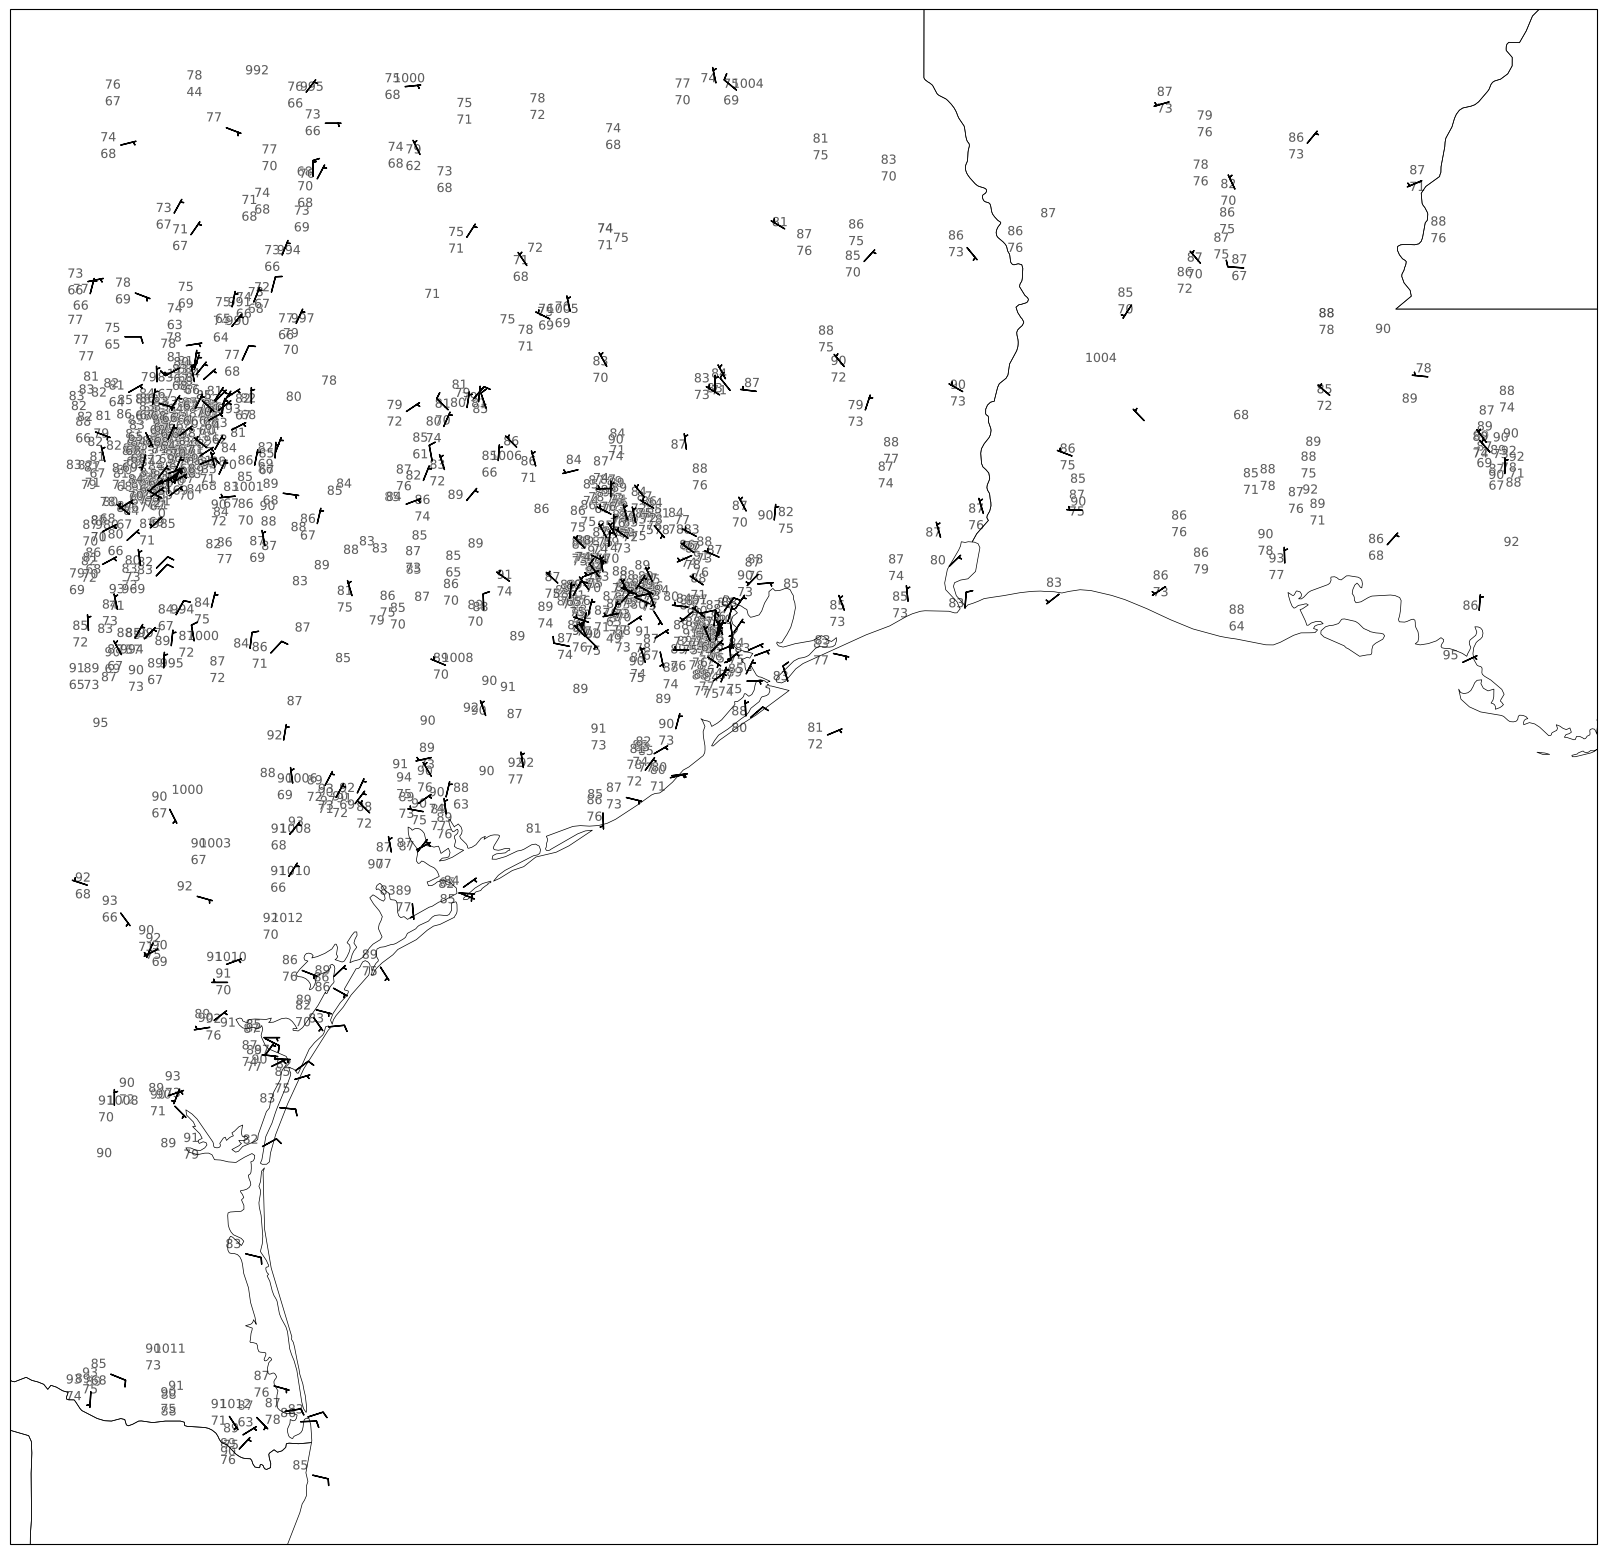

In [14]:
grid_x, grid_y, u_grid = interpolate_to_grid(latest_obs.longitude.data.compute(), latest_obs.latitude.data.compute(), u, interp_type='barnes', hres=0.01,
                                             boundary_coords={
                                                 'south': lim_mins[1],
                                                 'north': lim_maxs[1],
                                                 'west': lim_mins[0],
                                                 'east': lim_maxs[0]
                                             })
_, _, v_grid = interpolate_to_grid(latest_obs.longitude.data.compute(), latest_obs.latitude.data.compute(), v, interp_type='barnes', hres=0.01,
                                      boundary_coords={
                                            'south': lim_mins[1],
                                            'north': lim_maxs[1],
                                            'west': lim_mins[0],
                                            'east': lim_maxs[0]
                                        })
wind_xarray = xr.Dataset({
    'u' : xr.DataArray(u_grid.to('m/s'), dims=['latitude', 'longitude']),
    'v' : xr.DataArray(v_grid.to('m/s'), dims=['latitude', 'longitude'])
}, coords={
    'latitude': grid_y[:, 0],
    'longitude': grid_x[0, :]
})
div = mpcalc.divergence(wind_xarray.u, wind_xarray.v).data.m
divmx = np.nanmax(np.abs(div.data))
ax.pcolormesh(grid_x, grid_y, div, cmap='balance', transform=ccrs.PlateCarree(), vmin=-divmx, vmax=divmx, zorder=0)


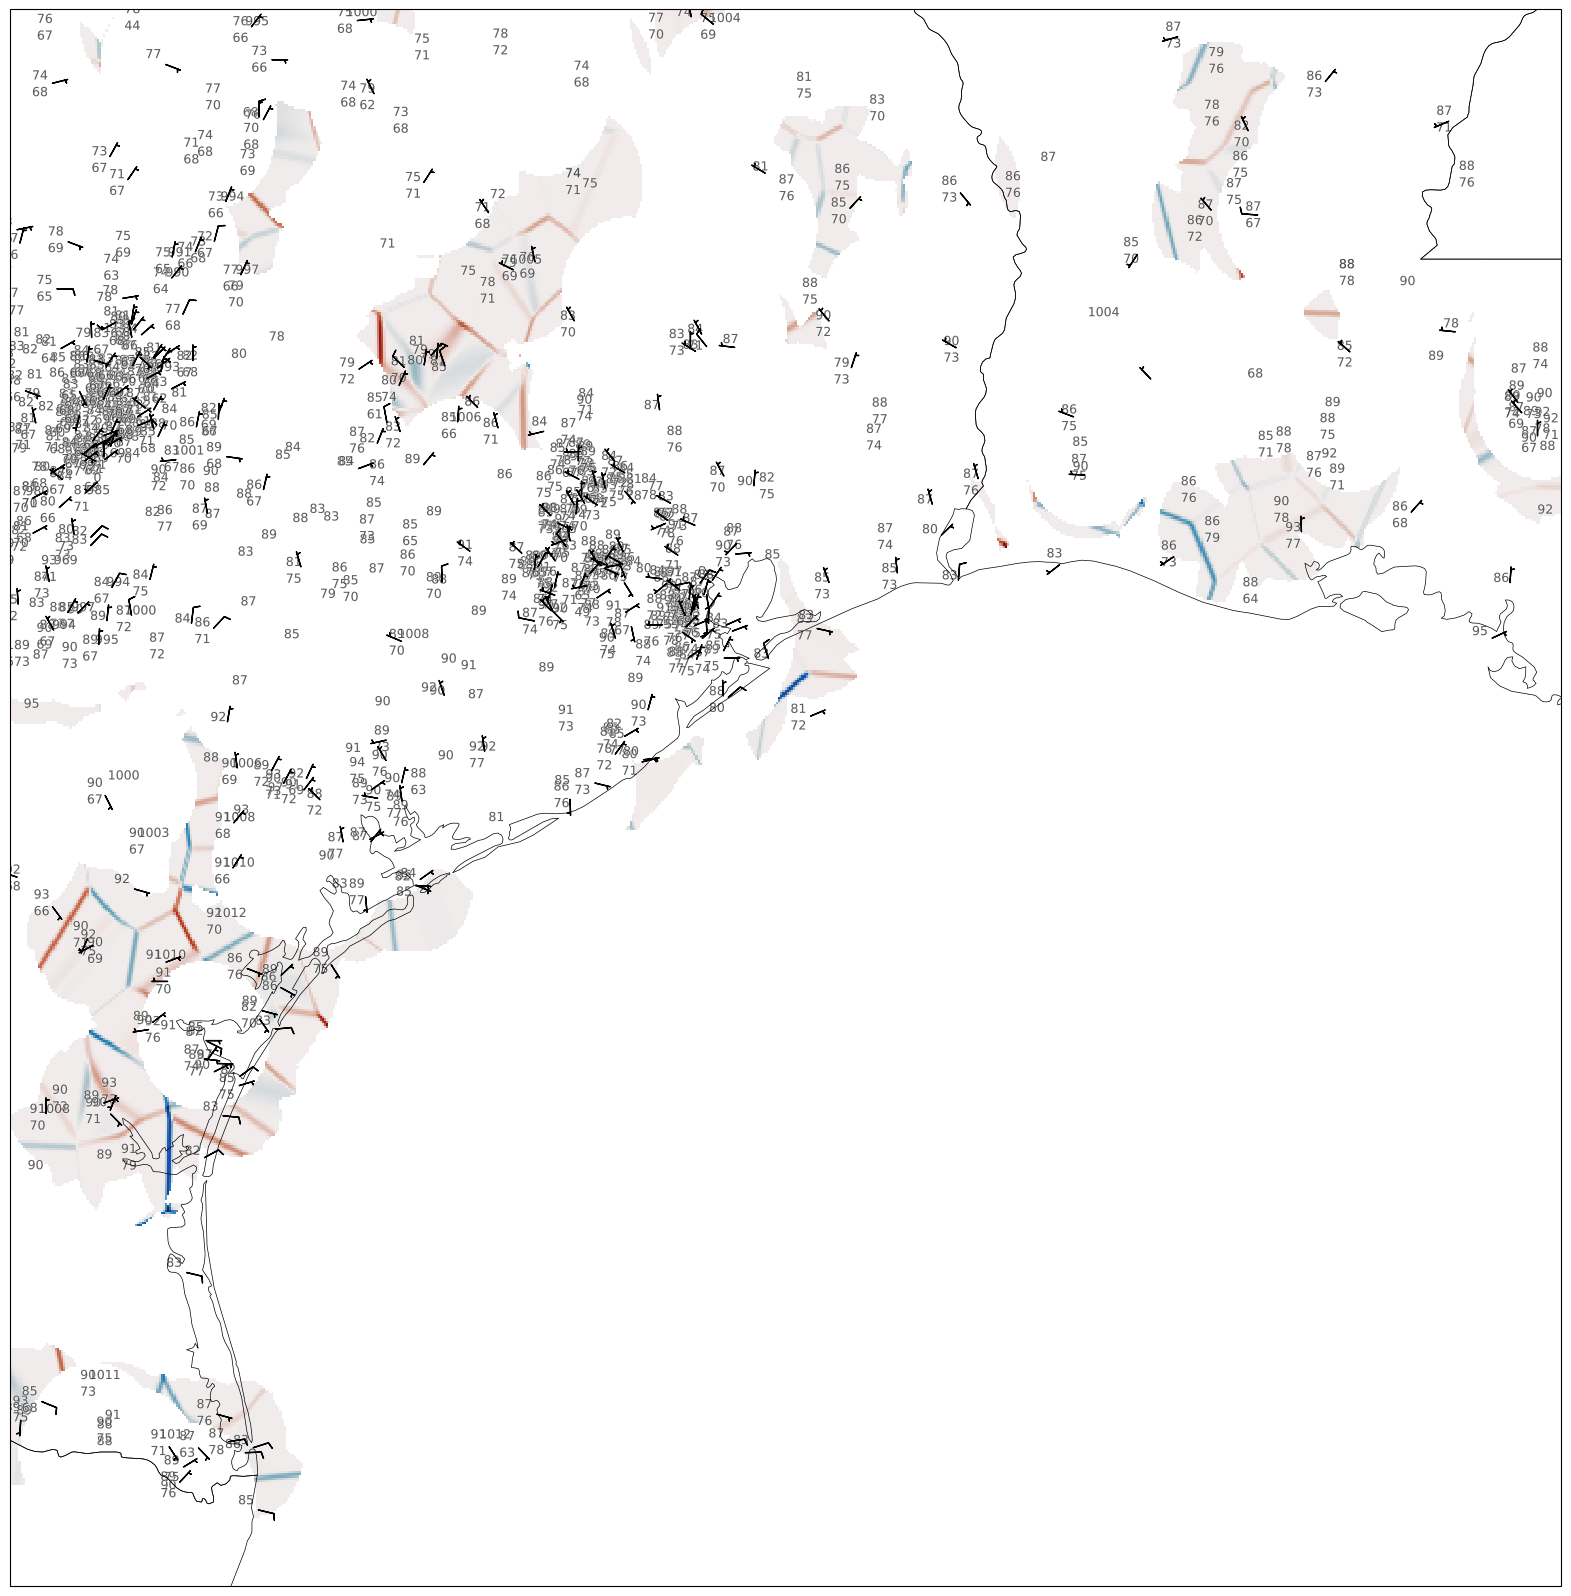

In [15]:
fig